In [ ]:
# default_exp learner

# Learner

> This contains fastai Learner extensions.

In [ ]:
#export
from fastai.learner import * 
from fastai.vision.models.all import *
from fastai.data.transforms import *
from tsai.imports import *
from tsai.data.core import *
from tsai.data.validation import *
from tsai.models.utils import *

In [ ]:
#export
@patch
def show_batch(self:Learner, **kwargs):
    self.dls.show_batch(**kwargs)

In [ ]:
#export
@patch
def save_all(self:Learner, path='export', dls_fname='dls', model_fname='model', learner_fname='learner', verbose=False):
    path = Path(path)
    if not os.path.exists(path): os.makedirs(path)

    self.dls_type = self.dls.__class__.__name__
    if self.dls_type == "MixedDataLoaders":
        self.n_loaders = (len(self.dls.loaders), len(self.dls.loaders[0].loaders))
        dls_fnames = []
        for i,dl in enumerate(self.dls.loaders):
            for j,l in enumerate(dl.loaders):
                l = l.new(num_workers=1)
                torch.save(l, path/f'{dls_fname}_{i}_{j}.pth')
                dls_fnames.append(f'{dls_fname}_{i}_{j}.pth')
    else:
        dls_fnames = []
        self.n_loaders = len(self.dls.loaders)
        for i,dl in enumerate(self.dls):
            dl = dl.new(num_workers=1)
            torch.save(dl, path/f'{dls_fname}_{i}.pth')
            dls_fnames.append(f'{dls_fname}_{i}.pth')

    # Saves the model along with optimizer
    self.model_dir = path
    self.save(f'{model_fname}', with_opt=True)

    # Export learn without the items and the optimizer state for inference
    self.export(path/f'{learner_fname}.pkl')
    
    pv(f'Learner saved:', verbose)
    pv(f"path          = '{path}'", verbose)
    pv(f"dls_fname     = '{dls_fnames}'", verbose)
    pv(f"model_fname   = '{model_fname}.pth'", verbose)
    pv(f"learner_fname = '{learner_fname}.pkl'", verbose)
    
    
def load_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner', device=None, pickle_module=pickle, verbose=False):

    if isinstance(device, int): device = torch.device('cuda', device)
    elif device is None: device = default_device()
    if device == 'cpu': cpu = True
    else: cpu = None

    path = Path(path)
    learn = load_learner(path/f'{learner_fname}.pkl', cpu=cpu, pickle_module=pickle_module)
    learn.load(f'{model_fname}', with_opt=True, device=device)

    
    if learn.dls_type == "MixedDataLoaders":
        dls_fnames = []
        _dls = []
        for i in range(learn.n_loaders[0]):
            _dl = []
            for j in range(learn.n_loaders[1]):
                l = torch.load(path/f'{dls_fname}_{i}_{j}.pth', map_location=device, pickle_module=pickle_module)
                l = l.new(num_workers=0)
                l.to(device)
                dls_fnames.append(f'{dls_fname}_{i}_{j}.pth')
                _dl.append(l)
            _dls.append(MixedDataLoader(*_dl, path=learn.dls.path, device=device, shuffle=l.shuffle))
        learn.dls = MixedDataLoaders(*_dls, path=learn.dls.path, device=device)

    else:
        loaders = []
        dls_fnames = []
        for i in range(learn.n_loaders):
            dl = torch.load(path/f'{dls_fname}_{i}.pth', map_location=device, pickle_module=pickle_module)
            dl = dl.new(num_workers=0)
            dl.to(device)
            first(dl)
            loaders.append(dl)
            dls_fnames.append(f'{dls_fname}_{i}.pth')
        learn.dls = type(learn.dls)(*loaders, path=learn.dls.path, device=device)


    pv(f'Learner loaded:', verbose)
    pv(f"path          = '{path}'", verbose)
    pv(f"dls_fname     = '{dls_fnames}'", verbose)
    pv(f"model_fname   = '{model_fname}.pth'", verbose)
    pv(f"learner_fname = '{learner_fname}.pkl'", verbose)
    return learn

load_learner_all = load_all

In [ ]:
#export
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, final_losses=True, perc=.5, **kwargs):
    n_values = len(self.recorder.values)
    if n_values < 2: 
        print('not enough values to plot a chart')
        return
    metrics = np.stack(self.values)
    n_metrics = metrics.shape[1]
    names = self.metric_names[1:n_metrics+1]
    if final_losses: 
        sel_idxs = int(round(n_values * perc))
        if sel_idxs >= 2:
            metrics = np.concatenate((metrics[:,:2], metrics), -1)
            names = names[:2] + names
        else: 
            final_losses = False
    n = len(names) - 1 - final_losses
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    axs = ([axs[0]]*2 + [axs[1]]*2 + axs[2:]) if final_losses else ([axs[0]]*2 + axs[1:])
    for i, (name, ax) in enumerate(zip(names, axs)):
        if i in [0, 1]:
            ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i == 1 else 'train')
            ax.set_title('losses')
            ax.set_xlim(0, len(metrics)-1)
        elif i in [2, 3] and final_losses:
            ax.plot(np.arange(len(metrics) - sel_idxs, len(metrics)), metrics[-sel_idxs:, i], 
                    color='#1f77b4' if i == 2 else '#ff7f0e', label='valid' if i == 3 else 'train')
            ax.set_title('final losses')
            ax.set_xlim(len(metrics) - sel_idxs, len(metrics)-1)
            # ax.set_xticks(np.arange(len(metrics) - sel_idxs, len(metrics)))
        else:
            ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
            ax.set_title(name if i >= 2 * (1 + final_losses) else 'losses')
            ax.set_xlim(0, len(metrics)-1)
        ax.legend(loc='best')
        ax.grid(color='gainsboro', linewidth=.5)
    plt.show()
    
    
@patch
@delegates(subplots)
def plot_metrics(self: Learner, **kwargs):
    self.recorder.plot_metrics(**kwargs)

In [ ]:
#export
@patch
@delegates(subplots)
def show_probas(self:Learner, figsize=(6,6), ds_idx=1, dl=None, one_batch=False, max_n=None, **kwargs):
    recorder = copy(self.recorder) # This is to avoid loss of recorded values while generating preds
    if one_batch: dl = self.dls.one_batch()
    probas, targets = self.get_preds(ds_idx=ds_idx, dl=[dl] if dl is not None else None)
    if probas.ndim == 2 and probas.min() < 0 or probas.max() > 1: probas = nn.Softmax(-1)(probas)
    if not isinstance(targets[0].item(), Integral): return
    targets = targets.flatten()
    if max_n is not None:
        idxs = np.random.choice(len(probas), max_n, False)
        probas, targets = probas[idxs], targets[idxs]
    fig = plt.figure(figsize=figsize, **kwargs)
    classes = np.unique(targets)
    nclasses = len(classes)
    vals = np.linspace(.5, .5 + nclasses - 1, nclasses)[::-1]
    plt.vlines(.5, min(vals) - 1, max(vals), color='black', linewidth=.5)
    cm = plt.get_cmap('gist_rainbow')
    color = [cm(1.* c/nclasses) for c in range(1, nclasses + 1)][::-1]
    class_probas = np.array([probas[i,t] for i,t in enumerate(targets)])
    for i, c in enumerate(classes):
        plt.scatter(class_probas[targets == c] if nclasses > 2 or i > 0 else 1 - class_probas[targets == c],
                    targets[targets == c] + .5 * (np.random.rand((targets == c).sum()) - .5), color=color[i], edgecolor='black', alpha=.2, s=100)
        if nclasses > 2: plt.vlines((targets == c).float().mean(), i - .5, i + .5, color='r', linewidth=.5)
    plt.hlines(vals, 0, 1)
    plt.ylim(min(vals) - 1, max(vals))
    plt.xlim(0,1)
    plt.xticks(np.linspace(0,1,11), fontsize=12)
    plt.yticks(classes, [self.dls.vocab[x] for x in classes], fontsize=12)
    plt.title('Predicted proba per true class' if nclasses > 2 else 'Predicted class 1 proba per true class', fontsize=14)
    plt.xlabel('Probability', fontsize=12)
    plt.ylabel('True class', fontsize=12)
    plt.grid(axis='x', color='gainsboro', linewidth=.2)
    plt.show()
    self.recorder = recorder

In [ ]:
#export
@delegates(build_ts_model)
def ts_learner(dls, arch=None, c_in=None, c_out=None, seq_len=None, d=None, splitter=trainable_params,
               # learner args
               loss_func=None, opt_func=Adam, lr=defaults.lr, cbs=None, metrics=None, path=None,
               model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
               # other model args
               **kwargs):

    if arch is None: arch = InceptionTime
    model = build_ts_model(arch, dls=dls, c_in=c_in, c_out=c_out, seq_len=seq_len, d=d, **kwargs)
    try:
        model[0], model[1]
        subscriptable = True
    except:
        subscriptable = False
    if subscriptable: splitter = ts_splitter
    learn = Learner(dls=dls, model=model,
                    loss_func=loss_func, opt_func=opt_func, lr=lr, cbs=cbs, metrics=metrics, path=path, splitter=splitter,
                    model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms, )

    # keep track of args for loggers
    store_attr('arch', self=learn)

    return learn

In [ ]:
#export
@delegates(build_tsimage_model)
def tsimage_learner(dls, arch=None, pretrained=False,
               # learner args
               loss_func=None, opt_func=Adam, lr=defaults.lr, cbs=None, metrics=None, path=None,
               model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
               # other model args
               **kwargs):

    if arch is None: arch = xresnet34
    model = build_tsimage_model(arch, dls=dls, pretrained=pretrained, **kwargs)
    learn = Learner(dls=dls, model=model,
                    loss_func=loss_func, opt_func=opt_func, lr=lr, cbs=cbs, metrics=metrics, path=path,
                    model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)

    # keep track of args for loggers
    store_attr('arch', self=learn)

    return learn

In [ ]:
#export
@patch
def decoder(self:Learner, o): return L([self.dls.decodes(oi) for oi in o])

In [ ]:
#export
@patch
@delegates(GatherPredsCallback.__init__)
def get_X_preds(self:Learner, X, y=None, **kwargs):
    return self.get_preds(dl=self.dls.new_dl(X, y=y), **kwargs)

In [ ]:
from tsai.data.all import *
from tsai.data.core import *
from tsai.models.FCNPlus import *
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, verbose=True, split_data=False)
tfms  = [None, [Categorize()]]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms)
learn = ts_learner(dls, FCNPlus, metrics=accuracy)
for p in learn.model.parameters():
    p.requires_grad=False
test_eq(count_parameters(learn.model), 0)
learn.freeze()
test_eq(count_parameters(learn.model), 1540)
learn.unfreeze()
test_eq(count_parameters(learn.model), 264580)

Dataset: OliveOil
X      : (60, 1, 570)
y      : (60,)
splits : (#30) [0,1,2,3,4,5,6,7,8,9...] (#30) [30,31,32,33,34,35,36,37,38,39...] 



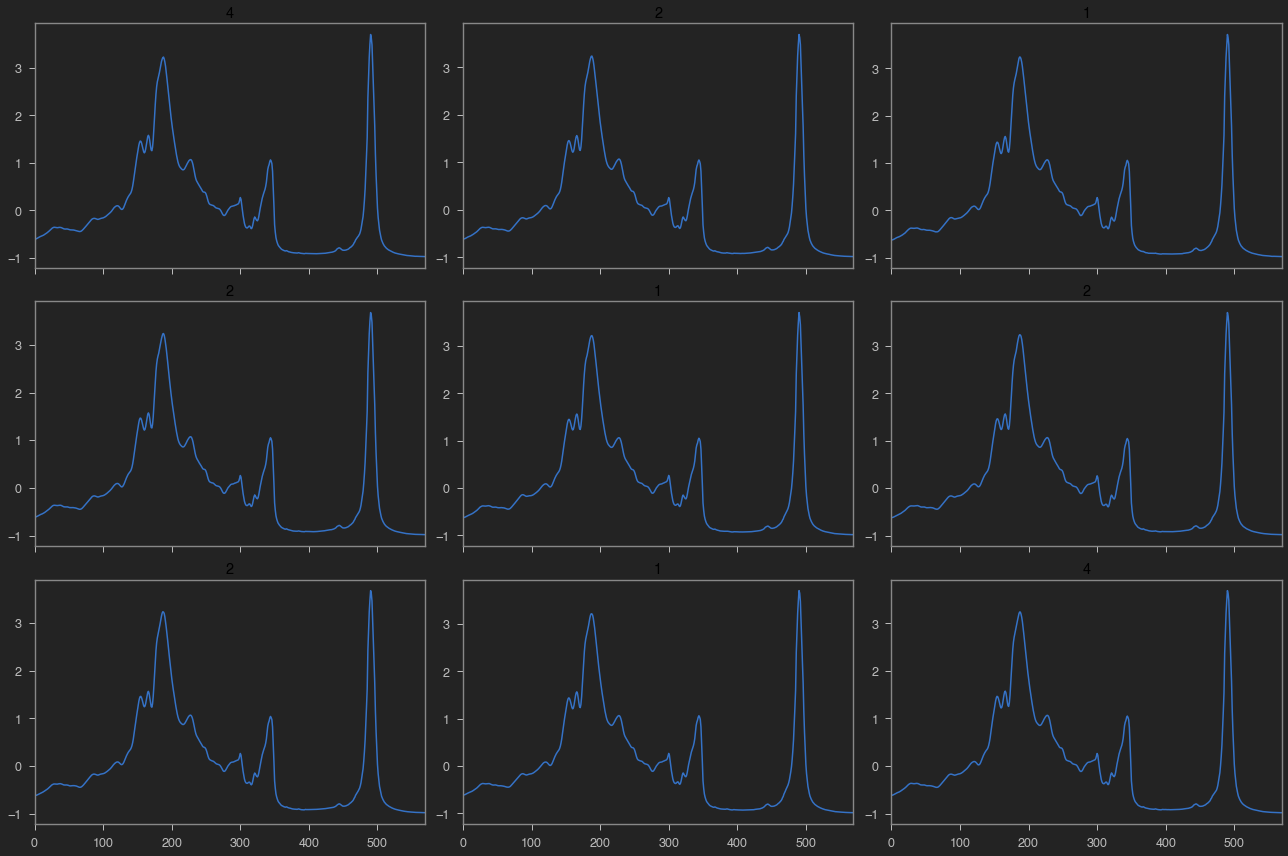

In [ ]:
learn.show_batch();

In [ ]:
learn.fit_one_cycle(2, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.429847,1.440586,0.133333,00:03
1,1.426278,1.389110,0.400000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.382794,1.356178,0.300000,00:03
1,1.380001,1.345537,0.300000,00:03


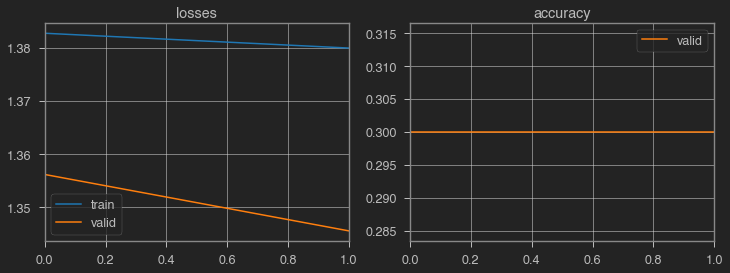

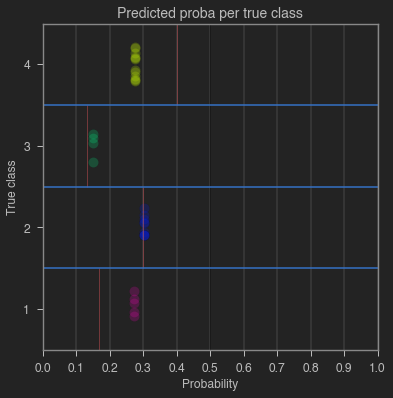

In [ ]:
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, split_data=False)
tfms  = [None, [Categorize()]]
dls = get_ts_dls(X, y, tfms=tfms, splits=splits)
learn = ts_learner(dls, FCNPlus, metrics=accuracy)
learn.fit_one_cycle(2)
learn.plot_metrics()
learn.show_probas()

In [ ]:
learn.save_all()
del learn
learn = load_all()

In [ ]:
test_probas, test_targets, test_preds = learn.get_X_preds(X[0:10], with_decoded=True)
test_probas, test_targets, test_preds

(tensor([[0.2736, 0.3010, 0.1509, 0.2745],
         [0.2736, 0.3010, 0.1509, 0.2745],
         [0.2736, 0.3010, 0.1509, 0.2745],
         [0.2736, 0.3010, 0.1509, 0.2745],
         [0.2737, 0.3010, 0.1508, 0.2745],
         [0.2736, 0.3010, 0.1510, 0.2744],
         [0.2736, 0.3010, 0.1509, 0.2744],
         [0.2736, 0.3010, 0.1509, 0.2744],
         [0.2736, 0.3010, 0.1510, 0.2744],
         [0.2736, 0.3010, 0.1509, 0.2744]]),
 None,
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [ ]:
learn.fit_one_cycle(1, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.334798,1.346682,0.300000,00:03


## TSClassifier API
***
```
TSClassifier(X, y=None, splits=None, tfms=defaults.cat_tfms, inplace=True, sel_vars=None, sel_steps=None, 
             bs=[64, 128], batch_size=None, batch_tfms=None, shuffle_train=True, drop_last=True, num_workers=0, do_setup=True, device=None,
             arch=None, arch_config={}, pretrained=False, weights_path=None, exclude_head=True, cut=-1, init=None,
             loss_func=None, opt_func=Adam, lr=0.001, metrics=accuracy, cbs=None, wd=None, wd_bn_bias=False,
             train_bn=True, moms=(0.95, 0.85, 0.95),  path='.', model_dir='models', splitter=trainable_params, verbose=False)
```
***

**Commonly used arguments:**
    
* **X:** array-like of shape (n_samples, n_steps) or (n_samples, n_features, n_steps). The input samples. Internally, they will be converted to torch tensors.
* **y:** array-like of shape (n_samples), (n_samples, n_outputs) or (n_samples, n_features, n_outputs). Internally, they will be converted to torch tensors. Default=None. None is used for unlabeled datasets. 
* **splits:** lists of indices used to split data between train and validation. Default=None. If no splits are passed, data will be split 80:20 between train and test without shuffling.
* **tfms:** item transforms that will be applied to each sample individually. Default=`[None, TSClassification()]` which is commonly used in most single label datasets. 
* **batch_tfms:** transforms applied to each batch. Default=None. 
* **bs:** batch size (if batch_size is provided then batch_size will override bs). An int or a list of ints can be passed. Default=`[64, 128]`. If a list of ints, the first one will be used for training, and the second for the valid (batch size can be larger as it doesn't require backpropagation which consumes more memory). 
* **arch:** indicates which architecture will be used. Default: InceptionTime.
* **arch_config:** keyword arguments passed to the selected architecture. Default={}.
* **pretrained:** indicates if pretrained model weights will be used. Default=False.
* **weights_path:** indicates the path to the pretrained weights in case they are used.
* **loss_func:** allows you to pass any loss function. Default=None (in which case CrossEntropyLossFlat() is applied).
* **opt_func:** allows you to pass an optimizer. Default=Adam.
* **lr:** learning rate. Default=0.001.
* **metrics:** list of metrics passed to the Learner. Default=accuracy.
* **cbs:** list of callbacks passed to the Learner. Default=None.
* **wd:** is the default weight decay used when training the model. Default=None.

**Less frequently used arguments:**

* **sel_vars:** used to select which of the features in multivariate datasets are used. Default=None means all features are used. If necessary a list-like of indices can be used (eg.`[0,3,5]`).
* **sel_steps:** used to select the steps used. Default=None means all steps are used. If necessary a list-like of indices can be used (eg. `slice(-50, None)` will select the last 50 steps from each time series).
* **inplace:** indicates whether tfms are applied during instantiation or on-the-fly. Default=True, which means that tfms will be applied during instantiation. This results in a faster training.
* **shuffle_train:** indicates whether to shuffle the training set every time the dataloader is fully read/iterated or not. This doesn't have an impact on the validation set which is never shuffled. Default=True.
* **drop_last:** if True the last incomplete training batch is dropped (thus ensuring training batches of equal size). This doesn't have an impact on the validation set where samples are never dropped. Default=True.
* **num_workers:** num_workers (int): how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. Default=0. 
* **do_setup:** ndicates if the Pipeline.setup method should be called during initialization. Default=True.
* **device:** Defaults to default_device() which is CUDA by default. You can specify device as `torch.device('cpu').
* **verbose:** controls the verbosity when fitting and predicting.
* **exclude_head:** indicates whether the head of the pretrained model needs to be removed or not. Default=True.
* **cut:** indicates the position where the pretrained model head needs to be cut. Defaults=-1.
* **init:** allows you to set to None (no initialization applied), set to True (in which case nn.init.kaiming_normal_ will be applied) or pass an initialization. Default=None.
* **splitter:** To do transfer learning, you need to pass a splitter to Learner. This should be a function taking the model and returning a collection of parameter groups, e.g. a list of list of parameters. Default=trainable_params. If the model has a backbone and a head, it will then be split in those 2 groups.
* **path** and **model_dir:** are used to save and/or load models. Often path will be inferred from dls, but you can override it or pass a Path object to model_dir.
* **wd_bn_bias:** controls if weight decay is applied to BatchNorm layers and bias. Default=False.
train_bn=True
* **moms:** the default momentums used in Learner.fit_one_cycle. Default=(0.95, 0.85, 0.95).

In [ ]:
#export
from tsai.models.InceptionTime import *

defaults.cat_tfms = [None, TSClassification()]

class TSClassifier(Learner):
    def __init__(self, X, y=None, splits=None, tfms=defaults.cat_tfms, inplace=True, sel_vars=None, sel_steps=None, 
                 bs=[64, 128], batch_size=None, batch_tfms=None, shuffle_train=True, drop_last=True, num_workers=0, do_setup=True, device=None,
                 arch=None, arch_config={}, pretrained=False, weights_path=None, exclude_head=True, cut=-1, init=None,
                 loss_func=None, opt_func=Adam, lr=0.001, metrics=accuracy, cbs=None, wd=None, wd_bn_bias=False,
                 train_bn=True, moms=(0.95, 0.85, 0.95),  path='.', model_dir='models', splitter=trainable_params, verbose=False):

        #Splits
        if splits is None: splits = TSSplitter()(X)

        # Batch size
        if batch_size is not None:
            bs = batch_size

        # DataLoaders
        dls = get_ts_dls(X, y=y, splits=splits, sel_vars=sel_vars, sel_steps=sel_steps, tfms=tfms, inplace=inplace, path=path, bs=bs,
                         batch_tfms=batch_tfms, num_workers=num_workers, device=device, 
                         shuffle_train=shuffle_train, drop_last=drop_last)

        # Model
        if init is True:
            init = nn.init.kaiming_normal_
        if arch is None:
            arch = InceptionTime
        if 'xresnet' in arch.__name__.lower() and not '1d' in arch.__name__.lower():
            model = build_tsimage_model(arch, dls=dls, pretrained=pretrained, init=init, device=device, verbose=verbose, **arch_config)
        elif 'tabularmodel' in arch.__name__.lower():
            build_tabular_model(arch, dls=dls, device=device, **arch_config)
        else:
            model = build_ts_model(arch, dls=dls, device=device, verbose=verbose, pretrained=pretrained, weights_path=weights_path,
                               exclude_head=exclude_head, cut=cut, init=init, **arch_config)
        setattr(model, "__name__", arch.__name__)
        try:
            model[0], model[1]
            splitter = ts_splitter
        except:
            pass

        super().__init__(dls, model, loss_func=loss_func, opt_func=opt_func, lr=lr, cbs=cbs, metrics=metrics, path=path, splitter=splitter,
                         model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)

In [ ]:
from tsai.models.InceptionTimePlus import *
X, y, splits = get_classification_data('OliveOil', split_data=False)
batch_tfms = [TSStandardize(by_sample=True)]
learn = TSClassifier(X, y, splits=splits, batch_tfms=batch_tfms, metrics=accuracy, arch=InceptionTimePlus, arch_config=dict(fc_dropout=.5))
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.303172,1.395615,0.400000,00:10


## TSRegressor API
***
```
TSRegressor(X, y=None, splits=None, tfms=defaults.reg_tfms, inplace=True, sel_vars=None, sel_steps=None,
            bs=[64, 128], batch_size=None, batch_tfms=None, shuffle_train=True, drop_last=True, num_workers=0, do_setup=True, device=None,
            arch=None, arch_config={}, pretrained=False, weights_path=None, exclude_head=True, cut=-1, init=None,
            loss_func=None, opt_func=Adam, lr=0.001, metrics=None, cbs=None, wd=None, wd_bn_bias=False,
            train_bn=True, moms=(0.95, 0.85, 0.95),  path='.', model_dir='models', splitter=trainable_params, verbose=False)
```
***

**Commonly used arguments:**
    
* **X:** array-like of shape (n_samples, n_steps) or (n_samples, n_features, n_steps). The input samples. Internally, they will be converted to torch tensors.
* **y:** array-like of shape (n_samples), (n_samples, n_outputs) or (n_samples, n_features, n_outputs). Internally, they will be converted to torch tensors. Default=None. None is used for unlabeled datasets. 
* **splits:** lists of indices used to split data between train and validation. Default=None. If no splits are passed, data will be split 80:20 between train and test without shuffling.
* **tfms:** item transforms that will be applied to each sample individually. Default=`[None, TSRegression()]` which is commonly used in most single label datasets. 
* **batch_tfms:** transforms applied to each batch. Default=None. 
* **bs:** batch size (if batch_size is provided then batch_size will override bs). An int or a list of ints can be passed. Default=`[64, 128]`. If a list of ints, the first one will be used for training, and the second for the valid (batch size can be larger as it doesn't require backpropagation which consumes more memory). 
* **arch:** indicates which architecture will be used. Default: InceptionTime.
* **arch_config:** keyword arguments passed to the selected architecture. Default={}.
* **pretrained:** indicates if pretrained model weights will be used. Default=False.
* **weights_path:** indicates the path to the pretrained weights in case they are used.
* **loss_func:** allows you to pass any loss function. Default=None (in which case CrossEntropyLossFlat() is applied).
* **opt_func:** allows you to pass an optimizer. Default=Adam.
* **lr:** learning rate. Default=0.001.
* **metrics:** list of metrics passed to the Learner. Default=None.
* **cbs:** list of callbacks passed to the Learner. Default=None.
* **wd:** is the default weight decay used when training the model. Default=None.

**Less frequently used arguments:**

* **sel_vars:** used to select which of the features in multivariate datasets are used. Default=None means all features are used. If necessary a list-like of indices can be used (eg.`[0,3,5]`).
* **sel_steps:** used to select the steps used. Default=None means all steps are used. If necessary a list-like of indices can be used (eg. `slice(-50, None)` will select the last 50 steps from each time series).
* **inplace:** indicates whether tfms are applied during instantiation or on-the-fly. Default=True, which means that tfms will be applied during instantiation. This results in a faster training.
* **shuffle_train:** indicates whether to shuffle the training set every time the dataloader is fully read/iterated or not. This doesn't have an impact on the validation set which is never shuffled. Default=True.
* **drop_last:** if True the last incomplete training batch is dropped (thus ensuring training batches of equal size). This doesn't have an impact on the validation set where samples are never dropped. Default=True.
* **num_workers:** num_workers (int): how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. Default=0. 
* **do_setup:** ndicates if the Pipeline.setup method should be called during initialization. Default=True.
* **device:** Defaults to default_device() which is CUDA by default. You can specify device as `torch.device('cpu').
* **verbose:** controls the verbosity when fitting and predicting.
* **exclude_head:** indicates whether the head of the pretrained model needs to be removed or not. Default=True.
* **cut:** indicates the position where the pretrained model head needs to be cut. Defaults=-1.
* **init:** allows you to set to None (no initialization applied), set to True (in which case nn.init.kaiming_normal_ will be applied) or pass an initialization. Default=None.
* **splitter:** To do transfer learning, you need to pass a splitter to Learner. This should be a function taking the model and returning a collection of parameter groups, e.g. a list of list of parameters. Default=trainable_params. If the model has a backbone and a head, it will then be split in those 2 groups.
* **path** and **model_dir:** are used to save and/or load models. Often path will be inferred from dls, but you can override it or pass a Path object to model_dir.
* **wd_bn_bias:** controls if weight decay is applied to BatchNorm layers and bias. Default=False.
train_bn=True
* **moms:** the default momentums used in Learner.fit_one_cycle. Default=(0.95, 0.85, 0.95).

In [ ]:
#export
#export
defaults.reg_tfms = [None, TSRegression()]      
        
class TSRegressor(Learner):
    def __init__(self, X, y=None, splits=None, tfms=defaults.reg_tfms, inplace=True, sel_vars=None, sel_steps=None, 
                 bs=[64, 128], batch_size=None, batch_tfms=None, shuffle_train=True, drop_last=True, num_workers=0, do_setup=True, device=None,
                 arch=None, arch_config={}, pretrained=False, weights_path=None, exclude_head=True, cut=-1, init=None,
                 loss_func=None, opt_func=Adam, lr=0.001, metrics=None, cbs=None, wd=None, wd_bn_bias=False,
                 train_bn=True, moms=(0.95, 0.85, 0.95),  path='.', model_dir='models', splitter=trainable_params, verbose=False):

        #Splits
        if splits is None: splits = TSSplitter()(X)

        # Batch size
        if batch_size is not None:
            bs = batch_size

        # DataLoaders
        dls = get_ts_dls(X, y=y, splits=splits, sel_vars=sel_vars, sel_steps=sel_steps, tfms=tfms, inplace=inplace, path=path, bs=bs,
                         batch_tfms=batch_tfms, num_workers=num_workers, device=device, 
                         shuffle_train=shuffle_train, drop_last=drop_last)

        # Model
        if init is True:
            init = nn.init.kaiming_normal_
        if arch is None:
            arch = InceptionTime
        if 'xresnet' in arch.__name__.lower() and not '1d' in arch.__name__.lower():
            model = build_tsimage_model(arch, dls=dls, pretrained=pretrained, init=init, device=device, verbose=verbose, **arch_config)
        elif 'tabularmodel' in arch.__name__.lower():
            build_tabular_model(arch, dls=dls, device=device, **arch_config)
        else:
            model = build_ts_model(arch, dls=dls, device=device, verbose=verbose, pretrained=pretrained, weights_path=weights_path,
                               exclude_head=exclude_head, cut=cut, init=init, **arch_config)
        setattr(model, "__name__", arch.__name__)
        try:
            model[0], model[1]
            splitter = ts_splitter
        except:
            pass

        super().__init__(dls, model, loss_func=loss_func, opt_func=opt_func, lr=lr, cbs=cbs, metrics=metrics, path=path, splitter=splitter,
                         model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)      

In [ ]:
from tsai.models.TST import *
X, y, splits = get_regression_data('AppliancesEnergy', split_data=False)
batch_tfms = [TSStandardize()]
learn = TSRegressor(X, y, splits=splits, batch_tfms=batch_tfms, arch=TST, metrics=mae, bs=512)
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,mae,time
0,234.759598,216.669800,14.312009,00:09


## TSForecaster API
***
```
TSForecaster(X, y=None, splits=None, tfms=defaults.fcst_tfms, inplace=True, sel_vars=None, sel_steps=None,
             bs=[64, 128], batch_size=None, batch_tfms=None, shuffle_train=True, drop_last=True, num_workers=None, do_setup=True, device=None,
             arch=None, arch_config={}, pretrained=False, weights_path=None, exclude_head=True, cut=-1, init=None,
             loss_func=None, opt_func=Adam, lr=0.001, metrics=None, cbs=None, wd=None, wd_bn_bias=False,
             train_bn=True, moms=(0.95, 0.85, 0.95),  path='.', model_dir='models', splitter=trainable_params, verbose=False)
```
***

**Commonly used arguments:**
    
* **X:** array-like of shape (n_samples, n_steps) or (n_samples, n_features, n_steps). The input samples. Internally, they will be converted to torch tensors.
* **y:** array-like of shape (n_samples), (n_samples, n_outputs) or (n_samples, n_features, n_outputs). Internally, they will be converted to torch tensors. Default=None. None is used for unlabeled datasets. 
* **splits:** lists of indices used to split data between train and validation. Default=None. If no splits are passed, data will be split 80:20 between train and test without shuffling.
* **tfms:** item transforms that will be applied to each sample individually. Default=`[None, TSForecasting()]` which is commonly used in most single label datasets. 
* **batch_tfms:** transforms applied to each batch. Default=None. 
* **bs:** batch size (if batch_size is provided then batch_size will override bs). An int or a list of ints can be passed. Default=`[64, 128]`. If a list of ints, the first one will be used for training, and the second for the valid (batch size can be larger as it doesn't require backpropagation which consumes more memory). 
* **arch:** indicates which architecture will be used. Default: InceptionTime.
* **arch_config:** keyword arguments passed to the selected architecture. Default={}.
* **pretrained:** indicates if pretrained model weights will be used. Default=False.
* **weights_path:** indicates the path to the pretrained weights in case they are used.
* **loss_func:** allows you to pass any loss function. Default=None (in which case CrossEntropyLossFlat() is applied).
* **opt_func:** allows you to pass an optimizer. Default=Adam.
* **lr:** learning rate. Default=0.001.
* **metrics:** list of metrics passed to the Learner. Default=None.
* **cbs:** list of callbacks passed to the Learner. Default=None.
* **wd:** is the default weight decay used when training the model. Default=None.

**Less frequently used arguments:**

* **sel_vars:** used to select which of the features in multivariate datasets are used. Default=None means all features are used. If necessary a list-like of indices can be used (eg.`[0,3,5]`).
* **sel_steps:** used to select the steps used. Default=None means all steps are used. If necessary a list-like of indices can be used (eg. `slice(-50, None)` will select the last 50 steps from each time series).
* **inplace:** indicates whether tfms are applied during instantiation or on-the-fly. Default=True, which means that tfms will be applied during instantiation. This results in a faster training.
* **shuffle_train:** indicates whether to shuffle the training set every time the dataloader is fully read/iterated or not. This doesn't have an impact on the validation set which is never shuffled. Default=True.
* **drop_last:** if True the last incomplete training batch is dropped (thus ensuring training batches of equal size). This doesn't have an impact on the validation set where samples are never dropped. Default=True.
* **num_workers:** num_workers (int): how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. Default=None. 
* **do_setup:** ndicates if the Pipeline.setup method should be called during initialization. Default=True.
* **device:** Defaults to default_device() which is CUDA by default. You can specify device as `torch.device('cpu').
* **verbose:** controls the verbosity when fitting and predicting.
* **exclude_head:** indicates whether the head of the pretrained model needs to be removed or not. Default=True.
* **cut:** indicates the position where the pretrained model head needs to be cut. Defaults=-1.
* **init:** allows you to set to None (no initialization applied), set to True (in which case nn.init.kaiming_normal_ will be applied) or pass an initialization. Default=None.
* **splitter:** To do transfer learning, you need to pass a splitter to Learner. This should be a function taking the model and returning a collection of parameter groups, e.g. a list of list of parameters. Default=trainable_params. If the model has a backbone and a head, it will then be split in those 2 groups.
* **path** and **model_dir:** are used to save and/or load models. Often path will be inferred from dls, but you can override it or pass a Path object to model_dir.
* **wd_bn_bias:** controls if weight decay is applied to BatchNorm layers and bias. Default=False.
train_bn=True
* **moms:** the default momentums used in Learner.fit_one_cycle. Default=(0.95, 0.85, 0.95).

In [ ]:
#export
defaults.fcst_tfms = [None, TSForecasting()]      
        
class TSForecaster(Learner):
    def __init__(self, X, y=None, splits=None, tfms=defaults.fcst_tfms, inplace=True, sel_vars=None, sel_steps=None, 
                 bs=[64, 128], batch_size=None, batch_tfms=None, shuffle_train=True, drop_last=True, num_workers=0, do_setup=True, device=None,
                 arch=None, arch_config={}, pretrained=False, weights_path=None, exclude_head=True, cut=-1, init=None,
                 loss_func=None, opt_func=Adam, lr=0.001, metrics=None, cbs=None, wd=None, wd_bn_bias=False,
                 train_bn=True, moms=(0.95, 0.85, 0.95),  path='.', model_dir='models', splitter=trainable_params, verbose=False):

        #Splits
        if splits is None: splits = TSSplitter()(X)

        # Batch size
        if batch_size is not None:
            bs = batch_size

        # DataLoaders
        dls = get_ts_dls(X, y=y, splits=splits, sel_vars=sel_vars, sel_steps=sel_steps, tfms=tfms, inplace=inplace, path=path, bs=bs,
                         batch_tfms=batch_tfms, num_workers=num_workers, device=device, 
                         shuffle_train=shuffle_train, drop_last=drop_last)

        # Model
        if init is True:
            init = nn.init.kaiming_normal_
        if arch is None:
            arch = InceptionTime
        if 'xresnet' in arch.__name__.lower() and not '1d' in arch.__name__.lower():
            model = build_tsimage_model(arch, dls=dls, pretrained=pretrained, init=init, device=device, verbose=verbose, **arch_config)
        elif 'tabularmodel' in arch.__name__.lower():
            build_tabular_model(arch, dls=dls, device=device, **arch_config)
        else:
            model = build_ts_model(arch, dls=dls, device=device, verbose=verbose, pretrained=pretrained, weights_path=weights_path,
                               exclude_head=exclude_head, cut=cut, init=init, **arch_config)
        setattr(model, "__name__", arch.__name__)
        try:
            model[0], model[1]
            splitter = ts_splitter
        except:
            pass

        super().__init__(dls, model, loss_func=loss_func, opt_func=opt_func, lr=lr, cbs=cbs, metrics=metrics, path=path, splitter=splitter,
                         model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)

Dataset: Sunspots
downloading data...
...data downloaded. Path = data/forecasting/Sunspots.csv


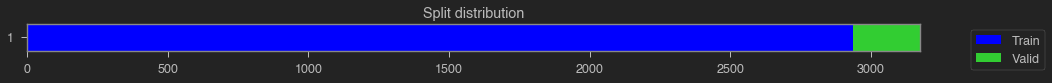

epoch,train_loss,valid_loss,mae,time
0,10920.277344,6304.904297,58.905022,01:03


In [ ]:
from tsai.models.TSTPlus import *
ts = get_forecasting_data('Sunspots')
X, y = SlidingWindowSplitter(60, horizon=1)(ts)
splits = TSSplitter(235)(y)
batch_tfms = [TSStandardize(by_var=True)]
learn = TSForecaster(X, y, splits=splits, batch_tfms=batch_tfms, arch=TST, arch_config=dict(fc_dropout=.5), metrics=mae, bs=512)
learn.fit_one_cycle(1)

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.core.ipynb.
Converted 011_callback.noisy_student.ipynb.
Converted 012_callback.gblend.ipynb.
Converted 013_callback.MVP.ipynb.
Converted 014_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_models.InceptionTimePlus.ipynb.
Conve